In [26]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



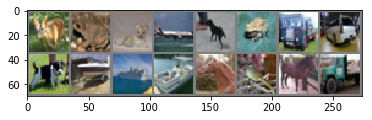

 deer  frog   dog plane


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [19]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_prototyping as util

# net = Net()
net = util.Unet(in_channels=3,
                 out_channels=3,
                 nf0=32,
                 num_down=5,
                 max_channels=512,
                 use_dropout=True,
                 upsampling_mode='transpose',
                 dropout_prob=0.2,
                 norm=nn.BatchNorm2d,
                 outermost_linear=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Unet(
  (in_layer): Sequential(
    (0): Conv2dSame(
      (net): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      )
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Dropout2d(p=0.1)
  )
  (unet_block): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): DownBlock(
        (net): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.2, inplace)
          (4): Dropout2d(p=0.2)
          (5): ReflectionPad2d((1, 1, 1, 1))
          (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [20]:
import torch.optim as optim

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.RMSprop(net.parameters(), lr=0.001)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [30]:
for epoch in range(1):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs_rescaled = (inputs/2+.5)
        
        ## Gaussian noise with sigma set to 0.05
        sigma = 0.05
        inputs_noisy = inputs_rescaled + sigma*torch.randn_like(inputs)
        
        ##end of Gaussian noise with sigma
        
        ##Poisson noise
        ## set mean for poisson noise
        # mean=0.003 
        # stddev=np.sqrt(mean)
        # inputs_noisy = inputs_rescaled + torch.from_numpy(np.random.normal(mean, stddev, inputs.shape)).float()
        
        ## end of Poisson noise
        
        ## Gaussian noise with mean and sigma 
        
        # mean=0.2
        # sigma=0.06
        # inputs_noisy = inputs_rescaled  + torch.from_numpy(np.random.normal(mean, sigma, inputs.shape)).float()
        
        ##end of Gaussian noise 
        
        inputs_noisy = 2 * torch.clamp(inputs_noisy, 0, 1) - 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs_noisy)
        outputs = torch.clamp(outputs/2 + .5, 0, 1)
        loss = criterion(outputs, inputs_rescaled)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 0.00524
[1,  1000] loss: 0.00488
[1,  1500] loss: 0.00479
[1,  2000] loss: 0.00455
[1,  2500] loss: 0.00441
[1,  3000] loss: 0.00441
Finished Training


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



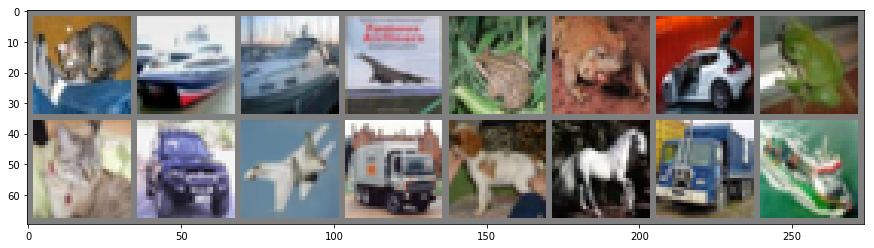

In [41]:
dataiter = iter(testloader)
images, labels = dataiter.next()

## Gaussian noise with sigma

images_noisy = (images/2+.5) + sigma*torch.randn_like(images)

## End of Gaussian noise

## Poisson noise

# images_noisy = (images/2+.5) + torch.from_numpy(np.random.normal(mean, stddev, images.shape)).float()

## End of Poisson noise

##Gaussian noise with mean and sigma

# images_noisy = (images/2+.5) + torch.from_numpy(np.random.normal(mean, sigma, images.shape)).float()

## End of Gaussian noise

images_noisy = 2 * torch.clamp(images_noisy, 0, 1) - 1


# print images
plt.figure(figsize=(15,6))
imshow(torchvision.utils.make_grid(images))

Okay, now let us see what the neural network thinks these examples above are:



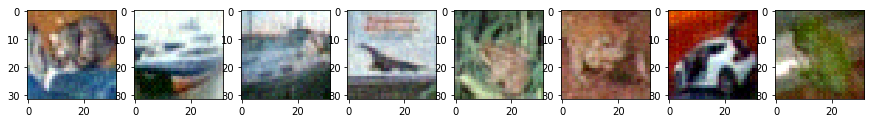

In [34]:
images, labels = images.to(device), labels.to(device)
images_rescaled = images/2+.5

## Gaussian noise with sigma

images_noisy = (images/2+.5) + sigma*torch.randn_like(images)

## End of Gaussian noise

## Poisson noise

# images_noisy = (images/2+.5) + torch.from_numpy(np.random.normal(mean, stddev, images.shape)).float()

## End of Poisson noise

##Gaussian noise with mean and sigma

# images_noisy = (images/2+.5) + torch.from_numpy(np.random.normal(mean, sigma, images.shape)).float()

## End of Gaussian noise

images_noisy = 2 * torch.clamp(images_noisy, 0, 1) - 1
    
outputs = net(images_noisy)
outputs = torch.clamp(outputs/2 + .5, 0, 1)

# print images
outputs_data = outputs.data
outputs_data = outputs_data.cpu()
outputs_data = outputs_data.numpy()


plt.figure(figsize=(15,6))
for i in range(8):
    output_img = outputs_data[i]
    output_img = np.transpose(output_img, (1,2,0))
    #output_img = output_img/2 + .5
    plt.subplot(1,8,i+1)
    plt.imshow(output_img)

plt.show()

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [35]:
mse = torch.mean(torch.mul(images_rescaled - outputs.data, images_rescaled - outputs), dim=(1,2,3))
psnr = 10*torch.log10(1/mse)
print(torch.mean(psnr))

tensor(25.4316, grad_fn=<MeanBackward1>)


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [36]:
correct = 0
total = 0
psnr_cumsum = 0
psnr_noisy_cumsum = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        images_rescaled = images/2+.5
        
        
        ## Gaussian noise with sigma
        
        images_noisy = torch.clamp(images_rescaled + sigma*torch.randn_like(images), 0, 1)
        
        ## end of Gaussian noise
        
        ## Poisson noise
        
        
        # images_noisy = torch.clamp(images_rescaled + torch.from_numpy(np.random.normal(mean, stddev, inputs.shape)).float(), 0, 1)
        
        ## End of Poisson noise
        
        
        ## Gaussian noise with mean and sigma
        
        # images_noisy = torch.clamp(images_rescaled + torch.from_numpy(np.random.normal(mean, sigma, inputs.shape)).float(), 0, 1)
            
        ## end of Gaussian noise
        
        inputs = 2 * images_noisy - 1
        outputs = net(inputs)
        outputs = torch.clamp(outputs/2 + .5, 0, 1)
        
        mse_noisy = torch.mean(torch.mul(images_rescaled - images_noisy, images_rescaled - images_noisy), dim=(1,2,3))
        psnr_noisy = 10*torch.log10(1/mse_noisy)
        mse = torch.mean(torch.mul(images_rescaled - outputs, images_rescaled - outputs), dim=(1,2,3))
        psnr = 10*torch.log10(1/mse)
        
        total += 16
        psnr_cumsum += torch.sum(psnr)
        psnr_noisy_cumsum += torch.sum(psnr_noisy)
        
        if total % 1000 == 0:
            print(psnr_cumsum/total, psnr_noisy_cumsum/total)
        

print('Mean PSNR: %.4f' % (psnr_cumsum/total))
print('Mean noisy PSNR: %.4f' % (psnr_noisy_cumsum/total))

tensor(24.3337) tensor(25.3862)
tensor(24.2884) tensor(25.3865)
tensor(24.2564) tensor(25.3888)
tensor(24.2121) tensor(25.3885)
tensor(24.2249) tensor(25.3893)
Mean PSNR: 24.2249
Mean noisy PSNR: 25.3893


In [14]:
torch.min(images)

tensor(-1.)